# Introduction

[This dataset][data] consists of 7,464 variables related to brain tumour detection, and a flag indicating the presence or absence of a brain tumour.

[data]: https://www.kaggle.com/datasets/jillanisofttech/brain-tumor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rc("figure", autolayout=True)
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

data = pd.read_csv("/kaggle/input/brain-tumor/data.csv", index_col=0)
print("There are {} rows and {:,} columns.\n".format(*data.shape))
data.head()

There are 36 rows and 7,465 columns.



,X53416,M83670,X90908,M97496,X90908.1,U37019,R48602,T96548,X64559,T55741,...,H87456,R64130,H11125.1,U22055,L22524,M13699.1,X54489,T55008,M10065.2,y
0,70,-81,25,10,22,113,36,163,9,25,...,75,5,68,138,53,-4,123,2,19,tumor
1,108,-30,-7,60,0,24,8,113,-3,9,...,186,6,60,93,140,-3,271,-1,-51,tumor
2,75,-1,5,48,6,34,27,35,-1,4,...,186,225,94,62,39,-14,127,7,192,tumor
3,871,4,14,78,-6,85,65,227,19,22,...,77,6,78,30,87,-4,59,3,367,tumor
4,-92,-34,14,19,11,-6,27,-8,9,-5,...,87,303,204,81,105,9,265,-2,126,tumor


# 1. Exploratory Data Analysis

## 1.1 Missing Values

There are no missing values. All columns have no (or zero) null values.

In [2]:
data.isna().sum().value_counts()

0    7465
dtype: int64

## 1.2 Data Types

The predictor variables were inferred (by *pandas*) to be *integers*. The response is a string (*object*).

In [3]:
data.dtypes.value_counts()

int64     7464
object       1
dtype: int64

We can use the `int16` dtype since the numeric values are within the range [-32,768, 32,767]. This cuts down memory usage by about 75%.

In [4]:
numeric_columns = data.select_dtypes("number")
print("Range of values:", 
      f"[{numeric_columns.min().min()}, {numeric_columns.max().max()}]\n"
      f"Size with {numeric_columns.dtypes.unique()[0]}:",
      f"{numeric_columns.memory_usage().sum() / 1024:.2f}KiB")

numeric_columns = numeric_columns.astype("int16")
print(f"Size with {numeric_columns.dtypes.unique()[0]}: "
      f"{numeric_columns.memory_usage().sum() / 1024:.2f}KiB")

Range of values: [-5655, 6628]
Size with int64: 2099.53KiB
Size with int16: 525.09KiB


## 1.3 Correlation

There are too many numeric variables to perform pairwise correlation analysis (7,464 variables == 27,851,916 variable pairs to compare). So we'll only view the top 15 positively and negatively correlated variables.

In [5]:
corr = data.corr().unstack()
print("Top 15 positively correlated:\n", "-"*28, "\n\n",
      # We select 30 and drop duplicates since correlation is symmetric
      # i.e. correlation(a, b) == correlation(b, a)
      corr[corr < 1].nlargest(30).drop_duplicates(),
      "\n\nTop 15 negatively correlated:\n", "-"*28, "\n\n", 
      corr.nsmallest(30).drop_duplicates(),
      sep="")

Top 15 positively correlated:
----------------------------

X90908    X90908.1    0.999657
          T64171      0.998909
          T55255      0.998765
T64171    T55255      0.998747
X90908.1  T55255      0.998714
          T64171      0.998128
M31516    M31516.1    0.997726
M10373    T63266      0.997556
T55255    T63266      0.997480
T64171    H71150      0.997409
M10373    H71150      0.997366
X90908.1  T63266      0.997275
T55255    H71150      0.997253
X90908    M10373      0.997135
          T63266      0.997127
dtype: float64

Top 15 negatively correlated:
----------------------------

U14518    T89991     -0.998389
H59796    D63882     -0.997120
H89939    H88522     -0.984687
M55513    M55513.1   -0.984583
H92523    H88522     -0.984557
H92279    T89991     -0.982657
R23924    M24902     -0.980429
H37925    H11125.1   -0.977597
R16250.1  X13897.1   -0.977312
X83857    H88522     -0.976782
T67704    M24902     -0.974658
R55241    H92523     -0.974356
M97388    T89991     -0.973

All the above variable-pairs exhibit very strong correlation. This can be remedied using dimension-reduction techniques like *Principal Component Analysis (PCA)*.

Surprisingly, only 35 components can account for almost all the variation in the numeric varibles.

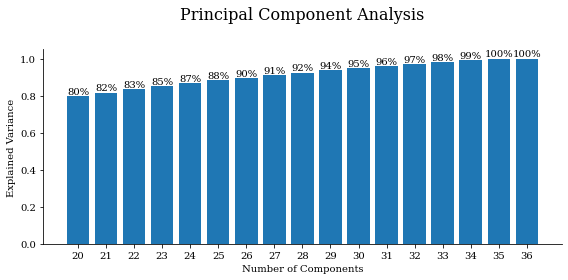

In [6]:
interval = range(20, 37)
variance_proportion = []
standardized_numeric_columns = StandardScaler().fit_transform(numeric_columns)

for n in interval:
    p = PCA(n).fit(standardized_numeric_columns)
    variance_proportion.append(p.explained_variance_ratio_.sum())

fig, ax = plt.subplots(figsize=(8, 4))
bars = plt.bar(interval, variance_proportion)
ax.bar_label(bars, [f"{x:.0%}" for x in variance_proportion])
ax.xaxis.set_major_locator(FixedLocator(interval))
ax.set_title("Principal Component Analysis", size=16, pad=30)
ax.set_xlabel("Number of Components")
_ = ax.set_ylabel("Explained Variance")

## 1.4 Target Distribution

The target variable is balanced. The proportion of each class is equal:

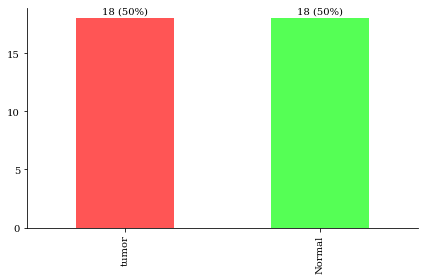

In [7]:
target_counts = data["y"].value_counts()
ax = target_counts.plot.bar(color=["#f55", "#5f5"])
_ = ax.bar_label(ax.containers[0], padding=3,
             labels=[f"{x} ({x / len(data):.0%})" for x in target_counts])
ax.yaxis.set_major_locator(FixedLocator(range(0, 20, 5)))

# 2. Modelling

We note that the number of columns (7464) is significantly larger than the number of rows (36). The dataset is so small that there's a high risk of overfitting on it. But we'll proceed anyway in the spirit of experimentation.

> **NOTE:** We won't be applying PCA in this case since the training data only has 27 rows, meaning we can't set `n_components` to 35.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(numeric_columns, data["y"],
                                                    random_state=2)

## 2.1 Random Forest Model

In [9]:
rf_model = RandomForestClassifier(random_state=5)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

1.0

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         5
       tumor       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



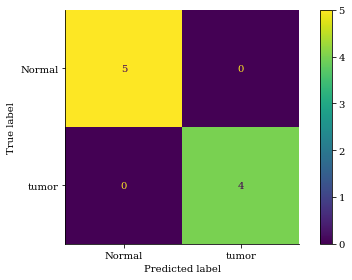

In [10]:
print(classification_report(y_test, rf_model.predict(X_test)))
ax = ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)

## 2.2 Logistic Regression Model

In [11]:
lr_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=5))
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

1.0

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         5
       tumor       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



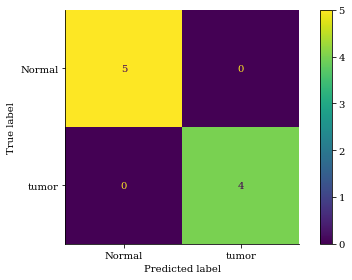

In [12]:
print(classification_report(y_test, lr_model.predict(X_test)))
ax = ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test)